# Kernel Methods for multivariate analysis
In this lab assignment we wil visit a **multimodality/multiple view** task in which the instances under study are **pictures and their captions**. The ultimate goal of the various research papers that have analysed these data in the past was to propose strategies for **content based information retrieval**. These papers were written in the early 2000's. Content based information retrieval has evolved since those early days; and more sophisticate techniques and features than the ones we are exploring in this assignment form the state of the art nowadays. However, these simple tasks addressed with simple methods can serve as a good starting point to gain insights and concept understanding about this field. 

In particular, this data set is borrowed from Hardoon, Szedmak and Shawe-Taylor 2004. There are three classes: sports, airplanes and paintball. Each class has 400 instances.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
def sorted_spectrum(A):
    complex_eig_val, complex_eig_vec = np.linalg.eig(A)
    eig_val = complex_eig_val.real
    orden = np.argsort(eig_val)[::-1]
    eig_val = eig_val[orden]
    eig_vec = complex_eig_vec.real
    eig_vec = eig_vec[:,orden]
    return eig_val, eig_vec

## Introduction

### Loading data
The data for the assignment is in 4 pickle archives:
- list_of_terms: dictionary of the words. It gives which word corresponds to each position of the bags-of-words
- targets: class of each instance
- pics_captions: actual data. Each register is a tuple with two elements:
 - RGB picture (array in 3 dimensions, Red, Green and Blue of each pixel in the photo)
 - caption of the picture: array of terms
- termDoc: Bags-of-words for each caption. Array with a bag-of-word per each caption. Each bag of word is an array with the size of the dictionary (list_of_terms). The position $[i,j]$ of the array is the number of times the $j$-th "word" in list_of_terms appears in the $i$-th caption. Extracted after some basic linguistic processing of the captions.

In [3]:
import scipy.io
mat = scipy.io.loadmat('datos.mat')
terms = mat['Terms']
termDoc = mat['termDoc']
y = mat['Target']
x = mat['x']
list_of_terms = [cc[0] for cc in terms[0]]

targets = y-1
   
pics_captions = [(x[0][cc][0], x[0][cc][1][0]) for cc in range(1200)]
termDoc = termDoc.T

### Plot some instances

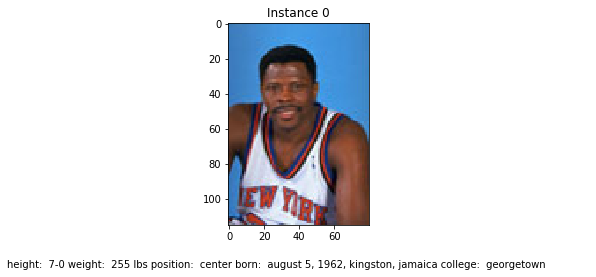

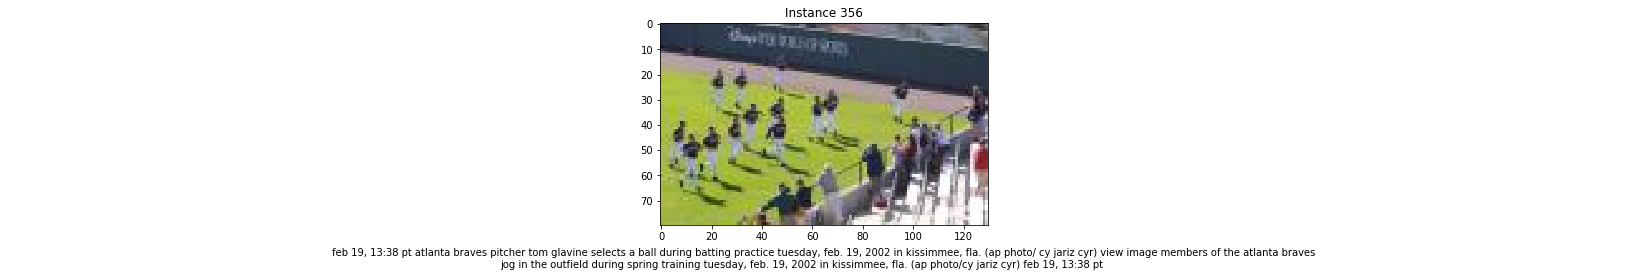

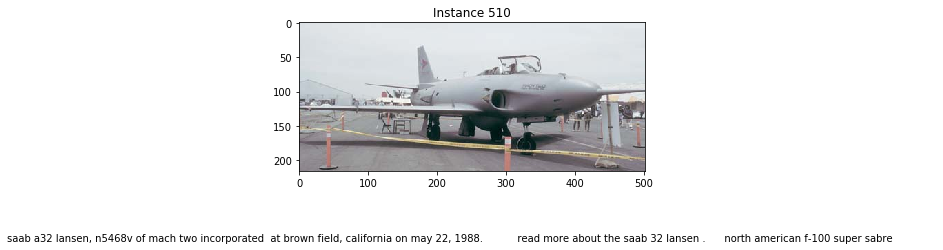

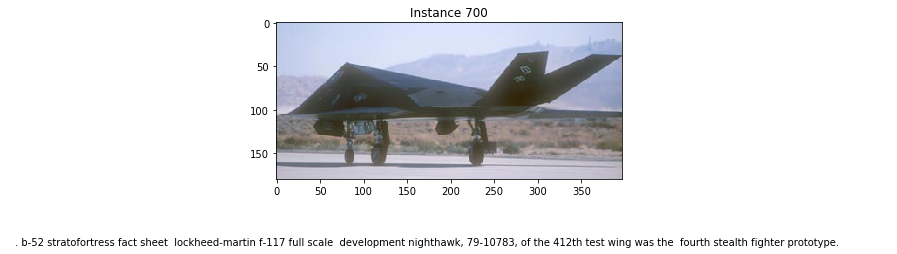

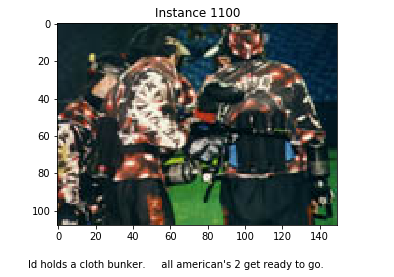

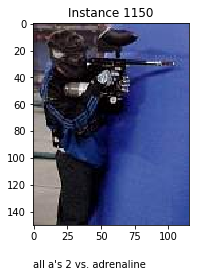

In [4]:
for ii in [0,356,510,700,1100,1150]:
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title("Instance {0:d}".format(ii))
    ax1.imshow(pics_captions[ii][0])
    txt=fig.text(.5, .05, pics_captions[ii][1],ha='center', wrap=True)
    txt._get_wrap_line_width = lambda : 1000.

### Bag-of-word example

The following code visualizes the captions and corresponding bag-of-words of two instances to illustrate the BOW concept.

In [5]:
for ii in [0, 607]:
    print("Instance {0:d}".format(ii))
    text = pics_captions[ii][1]
    print("original caption:")
    print(text)
    print("")
    print("Bag of words: \nword: number-of-occurrences")
    print("---------------------------")
    for jj,ww in enumerate(list_of_terms):
        if termDoc[ii,jj] > 0:
            print("{0}: {1:d}".format(ww, termDoc[ii,jj]))
    print("")
    print("")
    

Instance 0
original caption:
height:  7-0 weight:  255 lbs position:  center born:  august 5, 1962, kingston, jamaica college:  georgetown              

Bag of words: 
word: number-of-occurrences
---------------------------
born: 1
center: 1
college: 1
georgetown: 1
height: 1
jamaica: 1
lbs: 1
position: 1
weight: 1


Instance 607
original caption:
     ec-121d, 53-0555, c/n 4370      . pima air   space museum's page about ec-121t, 53-0554  ec-121d, 53-0555 at the air force  museum on august 16, 1998. its lockheed construction number is  4370.              

Bag of words: 
word: number-of-occurrences
---------------------------
air: 2
construction: 1
ec: 3
force: 1
lockheed: 1
museum: 2
number: 1
page: 1
pima: 1
space: 1




## Content based information retrieval

By content based information retrieval we think about a query/response system in which the **query is in a modality different from the one in which the actual search takes place**. For instance, in this particular case, people interested in retrieving pictures of airplanes would introduce a text query and the system would translate this query to image-wise features and perform a maximum similarity search in the space of the image features. The quick and dirty alternative content based information retrieval wanted to enhance was to index pictures with the wording of the caption. This is a single modality retrieval as the system would answer to the text query with pictures whose captions were similiar from a linguistic point of view to the text of the query. 

The underlying (and beautifully Platonic) idea supporting the techniques we are going to explore is the existence of a latent space (as Plato's world of ideas) in which the objects under study live and each view (text, image) is a mapping from this latent space to the space in which the view lives (bag-of-words or pixels). Therefore, two similar objects the latent feature space will map to close representations in both views. In this lab we are exploring some basic strategies to capture the latent feature space and use it to translate between the different views.

The typical use cases that we are going to look at are:
- **Given a picture find a suitable caption**. Well, we are not writing actual captions, just bags-of-words in the sense that some human (or natural language processing entity would have to use the bag-of-word retrieved for that picture and write a readable caption)
- **Given a text query retrieve relevant pictures**. Well, today we are querying with the bags-of-words of the test set instances and retrieving pictures of the same label. This application is very useful in news services when they need to prepare footage about a certain scene or person in the sense of retrieving clips or images where this scene or person appears.

# Description of features

We are working with three sets of features. One is the already mentioned bag-of-words, which is a feature that captures information from the textual view. The other two features capture information from the pixels:
- color histograms
- texture histograms

You are  given code that produces these two features that we comment now.

## Color histogram feature

Color is a fundamental information in images. The color feature that we are using is computed as follows:
- Split each image in a $4\times 4$ grid. The color feature will be the concatenation of the color histograms of the 16 patches.
- For each patch of each image: Transform the RGB information to [Hue, Saturation and Value](https://en.wikipedia.org/wiki/HSL_and_HSV)
- For each of the three components: H, S and V of each patch compute a histogram of 16 bins, equispaced between 0 and 1. This gives 48 numbers
- Concatenate the 48 numbers of each patch to yield 768 color features per image

In [6]:
from matplotlib.colors import rgb_to_hsv

def rgb2hsv(patch):
    # transforms RGB to HSV
    return rgb_to_hsv(patch/255.)

nbins = 16 # number bins per histogram
bins = np.linspace(0,1,nbins+1) # position of bins of each histogram between 0 and 1

n = len(pics_captions) # number of images
# number of patches per image
npatches_x = 4
npatches_y = 4
npatches = npatches_x * npatches_y

color_feature = np.empty((n, nbins * npatches *3)) # output with encodings of all the images
for imm in range(n):
    size= pics_captions[imm][0].shape[:2]
    range_x = np.linspace(0,size[0], npatches_x + 1,dtype=int)
    range_y = np.linspace(0,size[1], npatches_y + 1,dtype=int)
    isFirst = True
    for ii,ix in enumerate(range_x[:-1]):
        idx_x = range(range_x[ii],range_x[ii+1])
        for jj,iy in enumerate(range_y[:-1]):
            idx_y = range(range_y[jj],range_y[jj+1])
            # get patch in RGB
            patch = pics_captions[imm][0][idx_x,:,:][:,idx_y,:][:,:,:]
            # code patch in HSV
            patch_hsv = rgb2hsv(patch)
            # compute histogram of H, of S and of V and concatenate the three histograms
            histo1 = np.hstack([np.histogram(patch_hsv[:,:,hsv], bins, density=True)[0] for hsv in range(3)]) 
            # stack the 3 histograms of this patch with the other histograms of the same image
            if isFirst:
                isFirst = False
                histo = histo1.copy()     
            else:
                histo = np.hstack((histo, histo1))
    color_feature[imm,:] = histo.copy() # all the color features of image imm

### Examples Color Feature
For some of the examples plotted at the beginning of the notebook, display their 5 nearest neighbours and 5 furthest samples in the space of the color feature. This way we can gain insights about what is this feature capturing.

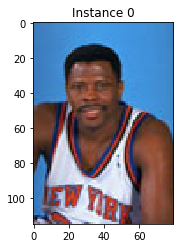

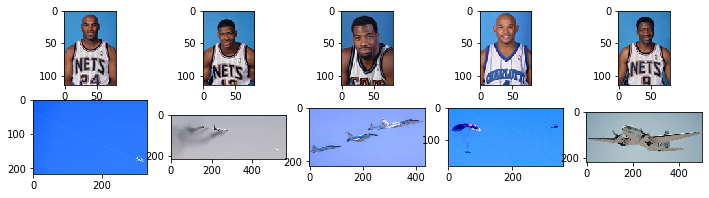

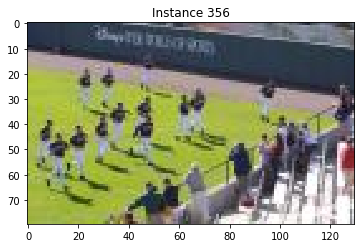

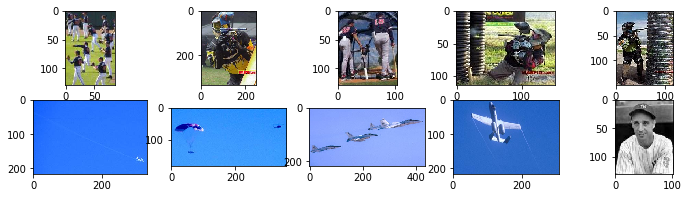

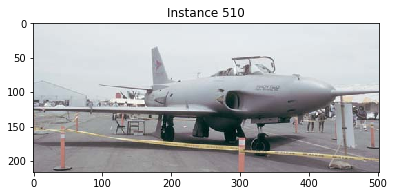

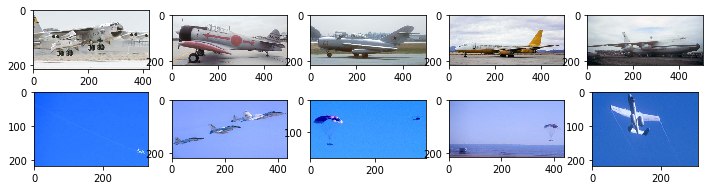

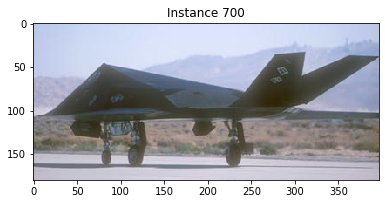

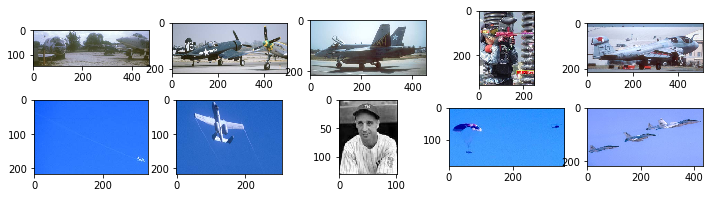

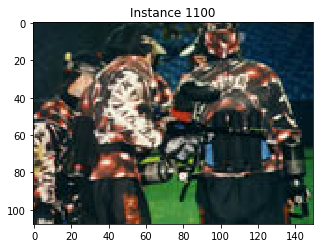

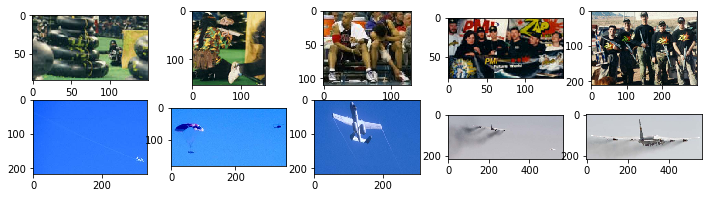

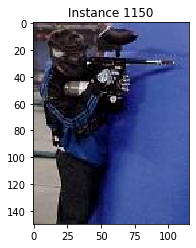

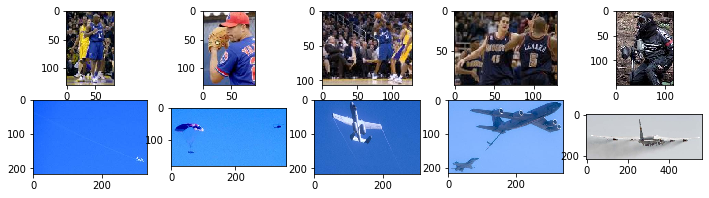

In [7]:
from sklearn.metrics.pairwise import rbf_kernel
"""
YOUR CODE
"""
KK = rbf_kernel(color_feature, gamma=0.005)
arg_sort_KK = np.argsort(KK,axis=1)
for ii in [0,356,510,700,1100,1150]:
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title("Instance {0:d}".format(ii))
    ax1.imshow(pics_captions[ii][0])
    ff,aa = plt.subplots(2,5,figsize=(12,3))
    for jj in range(5):
        nn = arg_sort_KK[ii,-(jj+2)]
        aa[0][jj].imshow(pics_captions[nn][0])
        nn = arg_sort_KK[ii,jj]
        aa[1][jj].imshow(pics_captions[nn][0])
        

## Texture Feature

The other important source of information in images are textures. We are using [Gabor filter banks](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html) to produce texture features. The filters are applied to the same patch structure that we used for the color features. For every patch we will be using the energy resulting from filtering the patch with a bank of 12 filters. This turns out in that each image will be coded into $16\times 12=192$ texture features.

In [8]:
from skimage.filters import gabor_kernel
from skimage.color import rgb2gray
# prepare filter bank kernels
kernels = []
v_theta  = np.array([0, np.pi/4, np.pi/2, np.pi/4*3])
v_freq = np.array([0.5, 0.2, 0.13])
sigma = 2
for theta in v_theta:
    for frequency in v_freq:
        kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
        kernels.append(kernel)


In [9]:
from scipy import ndimage as ndi
def compute_feats(image, kernels):
    feats = np.zeros(len(kernels), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k] = filtered.var() + filtered.mean()**2
    return feats

In [10]:
nfilters = len(v_theta) * len(v_freq)
texture_feature = np.empty((n, npatches * nfilters)) # output with encodings of all the images
for imm in range(n):
    size= pics_captions[imm][0].shape[:2]
    range_x = np.linspace(0,size[0], npatches_x +1, dtype=int)
    range_y = np.linspace(0,size[1], npatches_y +1, dtype=int)
    isFirst = True
    for ii,ix in enumerate(range_x[:-1]):
        idx_x = range(range_x[ii],range_x[ii+1])
        for jj,iy in enumerate(range_y[:-1]):
            idx_y = range(range_y[jj],range_y[jj+1])
            patch = pics_captions[imm][0][idx_x,:,:][:,idx_y,:][:,:,:]
            # textures work in the gray scale space, so RGB picture has to be transformed to gray scale
            patch_grayscale = rgb2gray(patch)
            textures1 = compute_feats(patch_grayscale, kernels)
            if isFirst:
                isFirst = False
                textures = textures1.copy()     
            else:
                textures = np.hstack((textures, textures1))
    texture_feature[imm,:] = textures.copy()

### Examples Texture Feature
For some of the examples plotted at the beginning of the notebook, display their 5 nearest neighbours and 5 furthest samples in the space of the color feature. This way we can gain insights about what is this feature capturing.

In [11]:
"""
YOUR CODE
"""

'\nYOUR CODE\n'

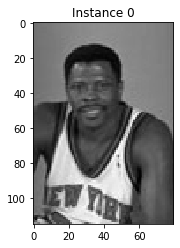

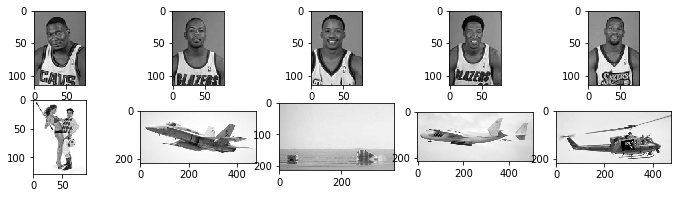

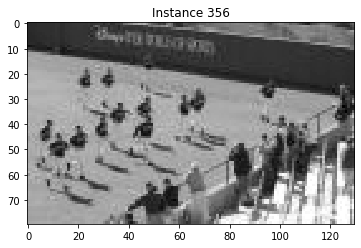

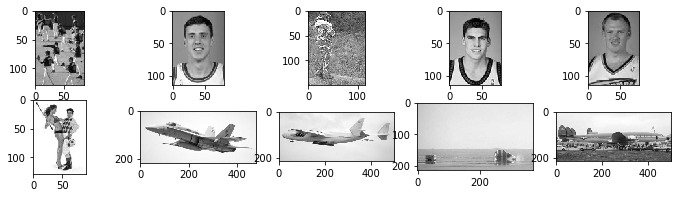

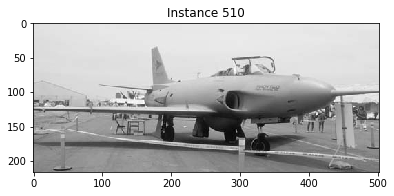

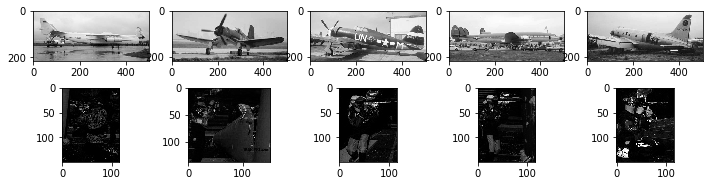

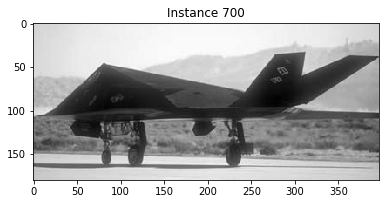

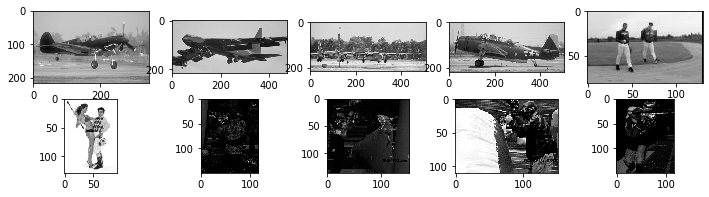

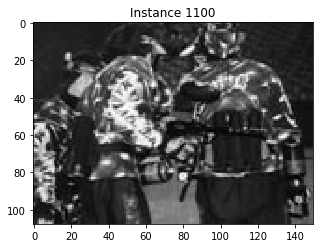

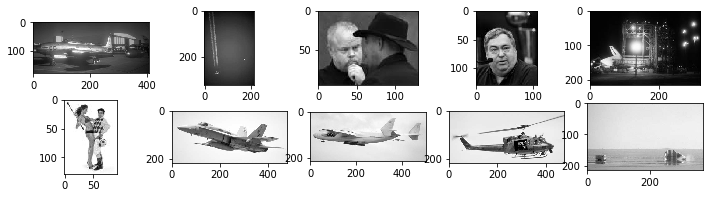

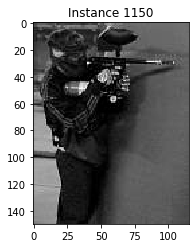

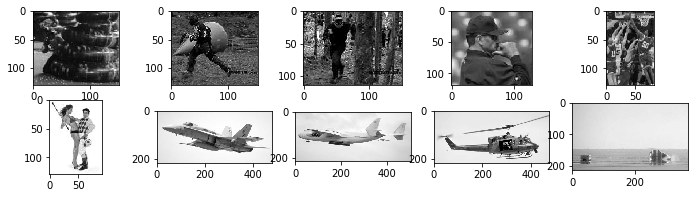

In [12]:
KK = rbf_kernel(texture_feature, gamma=50)
arg_sort_KK = np.argsort(KK,axis=1)
for ii in [0,356,510,700,1100,1150]:
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title("Instance {0:d}".format(ii))
    ax1.imshow(rgb2gray(pics_captions[ii][0]), cmap='gray')
    ff,aa = plt.subplots(2,5,figsize=(12,3))
    for jj in range(5):
        nn = arg_sort_KK[ii,-(jj+2)]
        aa[0][jj].imshow(rgb2gray(pics_captions[nn][0]), cmap='gray')
        nn = arg_sort_KK[ii,jj]
        aa[1][jj].imshow(rgb2gray(pics_captions[nn][0]), cmap='gray')

# Evaluate how easy is to classify with a single feature

The first part of the analysis is to gain insights about the expectations of the results. First we need to check how good are the selected set of features to separate the data. As the ultimate goal is to capture this latent space instead of you favourite classification algorithm we are using Kernel Linear Discriminant Analysis (KLDA).

The first taks is to code up KLDA as it is not available in sklearn.

All the MVA methods visited in the lecture study covariance matrices in Feature Space. Therefore, the first step to use the kernel matrix in the estimation of these covariances is its centering. By centering we mean to obtain a kernel matrix as by removing the sample mean of data in Feature Space. In other words, we first choose a kernel $\kappa(\mathbf x_i, \mathbf x_j)$. This kernel induces a feature space so that our data samples are mapped into their images $\mathbf h_i = \mathbf h(\mathbf x_i)$ and $\mathbf h_j = \mathbf h(\mathbf x_j)$ satisfying
$$
\kappa(\mathbf x_i, \mathbf x_j) = \mathbf h_i^\top \mathbf h_j
$$
Centering the kernel involves acting as if the mapped samples had their sample mean subtracted:
$$
\mathbf h_i \rightarrow \tilde{\mathbf h}_i =  \mathbf h_i - \frac{1}{n}\sum_{k=1}^n{\mathbf h_k}
$$

So the centred kernel can be computed as:
$$
\kappa_c(\mathbf x_i, \mathbf x_j) = \left ( \mathbf h_i - \frac{1}{n}\sum_{k=1}^n{\mathbf h_k} \right )^\top \left ( \mathbf h_j - \frac{1}{n}\sum_{k=1}^n{\mathbf h_k} \right )
$$

For the test set, we must use the **sample mean of the training set** as estimation of the mean, since we can't access the real mean. So for a test sample:
$$
\mathbf h(\mathbf x_t) \rightarrow \tilde{\mathbf h}_t =  \mathbf h_t - \frac{1}{n}\sum_{k=1}^n{\mathbf h_k}
$$

The following code implements a class called centred_kernel that computes centred kernels for the kernel functions we are using in this course, the rbf, the linear and the polynomial. It also stores the training set within the object so that it can provide with centred test set kernel matrices.

You need to complete the core code, the lines that actually centre the kernel matrix.

In [16]:
class centred_kernel(object):
    def __init__(self, kernel, centred=True, gamma=None, degree=None, coef0=None):
        self._kernel_type = kernel
        self._gamma = gamma
        self._degree = degree
        self._coef0 = coef0
        self._centred = centred
        
    def fit(self, X):
        self._X = X.copy()
        return self
    
    def fit_transform(self, X):
        self._X = X.copy()
        self._n = X.shape[0]
        if self._kernel_type == 'rbf':
            K = rbf_kernel(X, gamma=self._gamma)
        elif self._kernel_type == 'poly':
            K = polynomial_kernel(X, degree=self._degree, coef0=self._coef0)
        elif self._kernel_type == 'linear':
            K = linear_kernel(X)
        if self._centred == True:
            
            """
            YOUR CODE
            
            """
            sumK = np.sum(K,0)
            K1 = 1./self._n*np.tile(np.reshape(sumK,(-1,1)), (1,self._n))
            K2 = 1./self._n * np.tile(np.reshape(sumK,(1,-1)), (self._n,1))
            self._K = K.copy()
            Ko = K -  K1 - K2 + np.mean(K)
        else:
            Ko = K
        return Ko
    def transform(self, X):
        nt = X.shape[0]
        if self._kernel_type == 'rbf':
            K = rbf_kernel(X, self._X, gamma=self._gamma)
        elif self._kernel_type == 'poly':
            K = polynomial_kernel(X, self._X, degree=self._degree, coef0=self._coef0)
        elif self._kernel_type == 'linear':
            K = linear_kernel(X, self._X)
        if self._centred == True:
            
            """
            YOUR CODE
            """
            K1 = (K - 1./self._n * np.ones((nt, self._n)).dot(self._K))
            K2 = np.eye(self._n)- 1./self._n * np.ones((self._n, self._n))
            Ko = K1.dot(K2)
        else:
            Ko = K
        return Ko

## Code up the training of KLDA

- Inputs: 
 - $K_c$ (centred training kernel matrix), $K_c = K - \frac{1}{n}K\mathbf 1\mathbf 1^\top - \frac{1}{n}\mathbf 1\mathbf 1^\top K + - \frac{1}{n^2}\mathbf 1\mathbf 1^\top K\mathbf 1\mathbf 1^\top$ where $K(i,j) = \kappa(\mathbf x_i, \mathbf x_j)$ and $\mathbf 1$ is a column of ones
 - $y$ labels of training set
- Outputs:
 - $A$: $n\times P-1$ matrix with dual coefficients of the projection matrix in feature space
 - $Q$: $P\times P-1$ matrix with the projections of the mean of each class in feature space
- Process:
 - $S_B = \sum_{p=1}^P{n_p \left(\mathbf M_p - \mathbf M_* \right)\left(\mathbf M_p - \mathbf M_* \right)^\top}$
 - $ S_W = \sum_{p=1}^P{\frac{1}{n_p}K_{:p}K_{:p}^\top - \mathbf M_p \mathbf M_p^\top } $
 - Compute A = $P-1$ eigenvectors of largest eigenvalue of $S_W^{-1}S_B$
 - $Q_p = A^\top\mathbf M_p$ is the projection of the mean of class $p$, $p=1,\dots,P$

In [17]:
"""
YOUR CODE
"""

def kgda(K, y, tau = 1e-6):
    # K already centred!!
    n = K.shape[0]
    v_classes = np.unique(y)
    M_ = np.mean(K,1)
    P = len(v_classes)
    M_Mp = np.empty((n,P))
    #Sb
    Sb = np.zeros((n,n))
    Sw = np.zeros((n,n))
    for p in range(P):
        idx_class_p = np.where(y==v_classes[p])[0]
        n_p = len(idx_class_p)
        Kp = K[:,idx_class_p]
        Mp = np.mean(Kp,1)
        M_Mp[:,p] = Mp.copy()
        MpM_ = Mp - M_
        Sb += n_p* np.outer(MpM_, MpM_.T) # column * row
        Sw += 1./n_p* Kp.dot(Kp.T) - np.outer(Mp, Mp.T)
    #Sw inv
    if np.linalg.matrix_rank(Sw) < n:
        Sw += tau*np.eye(n)
    iSw = np.linalg.inv(Sw)
    AA = iSw.dot(Sb)
    DD2, UU2 = sorted_spectrum(AA)
    lam = DD2[:P-1]
    A = UU2[:,:P-1]
    VMp = A.T.dot(M_Mp)
    return A, VMp.T

## Code up the evaluation of KLDA
Once the training is finshed, we need to use the KLDA to classify patterns. Your code needs to implement the following algorithm
- Inputs: 
 - $K_t$: $n_t\times n$ centred test kernel matrix. Remember you need the training set
 - $A$: Dual coefficients of the projection in feature space
 - $Q$: projections of the means of each class
- Outputs:
 - $t$: predicted targets
 - $U$: $n_t\times P-1$ matrix with the projections of the test samples in feature space
- Process:
 - $U=A^\top K_t$, 
 - $t[i] = \mbox{argmin}_p D(Q_p, U_{i:})$, $i=1,\dots,n_t$

In [18]:
"""
YOUR CODE
"""
from sklearn.metrics import pairwise_distances
def predict_kgda(K_test, A, Q, v_classes=None):
    # Ktest centred!!
    # Q projection of class means!!
    if v_classes is None:
        P = Q.shape[0]
        v_classes = np.array([int(cc) for cc in range(P)])
    U = K_test.dot(A)
    Distance_sample_mean = pairwise_distances(U, Q)
    closest_mean = np.argmin(Distance_sample_mean,1)
    output = np.array([v_classes[ii] for ii in closest_mean])
    return output, U

## Evaluation of the discriminating capability of the color feature

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

"""
YOUR CODE

- split data in training/test partition with 50% of samples
- color_train of size [600, 768] has the training set instances, color_test has the test set
- Standarize using StandardScaler fitted with training data
- determine gamma

"""

orden = np.random.permutation(1200)
idx_train = orden[:600]
idx_test = orden[600:]
y_train = targets[0][idx_train]
y_test = targets[0][idx_test]

color_train = color_feature[idx_train, :]
color_test = color_feature[idx_test, :]

color_scaler = StandardScaler()
color_train_n = color_scaler.fit_transform(color_train)
color_test_n = color_scaler.transform(color_test)

gamma_color = 0.005

kernel_color = centred_kernel(kernel='rbf', gamma=gamma_color)
K_color_train = kernel_color.fit_transform(color_train_n)
K_color_test = kernel_color.transform(color_test_n)

A, Q = kgda(K_color_train, y_train)
pred_train, U_train = predict_kgda(K_color_train, A, Q)
pred_test, U_test = predict_kgda(K_color_test, A, Q)
print("Error Training set: {0:.1f}%".format(100*np.mean(y_train != pred_train)))
print("Error Test set: {0:.1f}%".format(100*np.mean(y_test != pred_test)))

Error Training set: 0.0%
Error Test set: 18.7%


### Scatter plots 

In [20]:
### Scatter plots 
def pinta(U, y, ax):
    v_classes = np.unique(y)
    for ii in v_classes:
        ax.scatter(U[y==ii,0], U[y==ii,1], alpha=0.4)
   


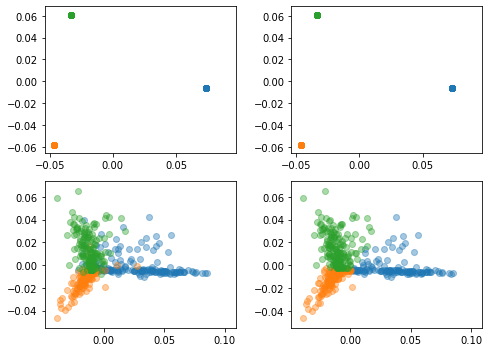

In [21]:
ff, ax = plt.subplots(2,2,figsize=(7,5))
pinta(U_train, y_train, ax[0][0])
pinta(U_train, pred_train, ax[0][1])
pinta(U_test, y_test, ax[1][0])
pinta(U_test, pred_test, ax[1][1])
ff.tight_layout()

<ipython-input-23-b2bfdbeeddc2>:43: UserWarning: No contour levels were found within the data range.
  a1.contour(X, Y, zz, [0,1], linestyles='dashed', colors='black')


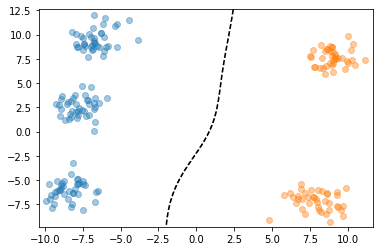

In [23]:
######################################
### EXAMPLE NON-LINEAR BOUNDARY IN 2D
######################################
def z_grid(Xg, Yg, z):
    # get grid evaluation of function z in points
    # defined by ranges Xg and Yg
    Ng, Mg = len(Xg), len(Yg)
    Z = np.zeros((Ng, Mg))
    for i, (x,y) in enumerate(product(Xg,Yg)):
        Z[np.unravel_index(i, (Ng,Mg))] = z(np.array([x,y]))
    return Z
from sklearn.datasets.samples_generator import make_blobs
xc, yc = make_blobs(200, centers=5)
yc[yc==4]=1
yc[yc==3]=2
yc[yc==2]=0
f1,a1 = plt.subplots(1,1)
pinta(xc,yc,a1)

kr = centred_kernel(kernel='rbf', gamma=0.02)
Kc = kr.fit_transform(xc[:100,:])
Kt = kr.transform(xc[100:,:])

Ac, Qc = kgda(Kc, yc[:100])
pred_r_c, U_c_train = predict_kgda(Kc, Ac, Qc)
pred_r_test, U_c_test = predict_kgda(Kt, Ac, Qc)

xmin = np.min(xc[:,0])
xmax = np.max(xc[:,0])
Xg = np.arange(xmin-.05*np.absolute(xmin),
               xmax + .05*np.absolute(xmax),
               0.01) # or whatever values for x
ymin = np.min(xc[:,1])
ymax = np.max(xc[:,1])
Yg = np.arange(ymin-.05*np.absolute(ymin),
               ymax + .05*np.absolute(ymax),
               0.01)   # or whatever values for y
X, Y = np.meshgrid(Xg, Yg)
ZZ = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
Kgrid = kr.transform(ZZ)
pred_r_grid, U_c_grid = predict_kgda(Kgrid, Ac, Qc)
zz = pred_r_grid.reshape((X.shape[0], X.shape[1]))
a1.contour(X, Y, zz, [0,1], linestyles='dashed', colors='black')

## Check with kernel PCA

We can compare the projections learned by KLDA with those learnt by Kernel PCA. [KPCA is available from sklearn](https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html#sphx-glr-auto-examples-decomposition-plot-kernel-pca-py). In first place we can compute the best two projections, for the color feature using all the training data and evaluate with the test data

In [ ]:
"""
YOUR CODE
- instantiate KPCA, kernel precomputed
- fit with training data, kernel of color component
- transform training data 
- scater plot
"""

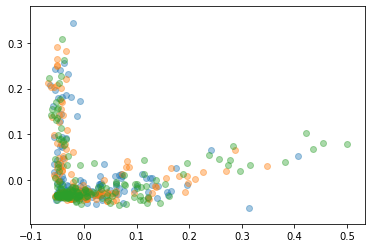

In [24]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(kernel="precomputed")
X_kpca = kpca.fit_transform(K_color_train)
Test_kpca = kpca.transform(K_color_train)[:,:2]
ff,aa = plt.subplots(1,1)
pinta(Test_kpca, y_test,aa)

We can use a bit of supervision by learning 3 KPCAs, one separate KPCA with the members of just one class.

In [ ]:
"""
YOUR CODE
- loop for each class
- create KPCA with the kernel matrix of the samples of class i
- transform all test samples
- scatter plot
"""

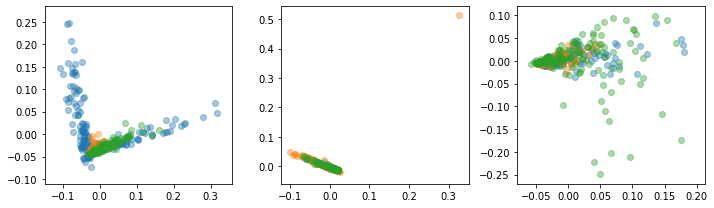

In [25]:
ff,aa = plt.subplots(1,3, figsize=(10,3))
for lab in range(3):
    kpca = KernelPCA(kernel="precomputed")
    X_kpca = kpca.fit_transform(K_color_train[y_train==lab,:][:,y_train==lab])
    Test_kpca = kpca.transform(K_color_test[:,y_train==lab])[:,:2]
    pinta(Test_kpca, y_test,aa[lab])
ff.tight_layout()

# Evaluation of KCCA code

This notebook includes my own (scarcely tested) implementation of the KCCA algorithm of Hardoon, Szedmak and Shawe-Talyor 2004. The next step in the notebook is to get familiar with the use of this implementation. It has three fundamental methods:
- __init__ to create a new instance just type my_cca=KCCA(parameters). Input arguments are:
 - n_components: maximum number of components of the projection
 - dim_first_view: To use a standard fit and transform methods, that read a single parameter X I have used the following way to introduce two views: X[:,:dim_first_view] are the observations of the first view while X[: , dim_first_view:] are the observations of the second view. Same for precomputed kernel. 'half' means the first half of the columns of X are the first view
 - kernel1: kernel of the first view.'linear' is default. It can also be 'precomputed', 'rbf', 'poly' 
 - kernel2: kernel of the second view.'linear' is default. It can also be 'precomputed', 'rbf', 'poly'
 - center_kernels: True is default. Center the kernels
 - gamma1: gamma for rbf kernel in the first view 
 - gamma2: gamma for rbf kernel in the second view 
 - degree1: degree for poly kernel in the first view  
 - degree2: degree for poly kernel in the second view
 - coef0_1: coef_0 for poly kernel in the first view
 - coef0_2: coef_0 for poly kernel in the second view
 - tau: regularizer for PGSD 1e-6 is default
- **fit**: Learns the KCCA with the views given in np.array X. It produces:
 - self._w1: dual weights of the Canonical Components for the first view 
 - self._w2: dual weights of the CCs for the second view 
 - self._lambdas: eigenvalues corresponding to each CC
- **transform**: computes the projection of the two views of X in their canonical components. The output is an array with the same structure of X: the first n_components columns correspond to the first view and the last n_components columns to the second
- **fit_transform**

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.linalg import eig

def normalize(x):
    x_mod = np.linalg.norm(x,2,axis=0)
    return x / np.tile(x_mod.reshape(1,-1),(x.shape[0],1))

def _core(eta,K):
    n = K.shape[0]
    thres = eta * np.trace(K)
    
    nu = np.zeros(n)
    I = np.zeros(n, dtype=int)
    R = np.zeros((n, n))
    d = np.diag(K).copy()
    
    for jj in range(n):
        if np.sum(d) < thres:
            #print("hola, PGSO limit")
            #print("n= {0:d}, jj={1:d}".format(int(n),jj))
            jj -=1
            break
        I[jj] = np.argmax(d)
        a = d[I[jj]]
        nu[jj] = np.sqrt(a)
        for ii in range(n):
            R[ii,jj] = (K[ii,I[jj]] - R[ii,:jj].dot(R[I[jj],:jj]))/nu[jj]
            d[ii] = d[ii]-(R[ii,jj]**2)
    s_T = jj+1
    s_R = R[:,:s_T]
    s_nu = nu[:s_T]
    s_I = I[:s_T]
    return s_T, s_R, s_nu, s_I
class PGSO(object):
    def __init__(self, eta=1e-3):
        self._eta = eta
   
    def fit(self, K):
        self._T, self._R, self._nu , self._I = _core(self._eta, K)
        return self
    def fit_transform(self, K):
        self._T, self._R, self._nu , self._I = _core(self._eta, K)
        return self._R.copy()
    def transform(self, K):
        nt = K.shape[0]
        R = np.zeros((nt, self._T))
        for ii in range(nt):
            for jj in range(self._T):
                R[ii,jj] = (K[ii, self._I[jj]] - R[ii,:].dot(self._R[self._I[jj],:]))/self._nu[jj]
        return R

def reg_cca(Rx, Ry, n_components=None, tau=1e-3, normalized=False):
    n = Rx.shape[0]
    Zxx = Rx.T.dot(Rx)/n
    Zyy = Ry.T.dot(Ry)/n
    Zxy = Rx.T.dot(Ry)/n
    Zyx = Ry.T.dot(Rx)/n

    Mx = Zxx + tau*np.eye(Zxx.shape[0])
    My = Zyy + tau*np.eye(Zyy.shape[0])

    if Mx.shape[0] < My.shape[0]:
        #solve problem in y view
        S = PGSO(eta=0).fit_transform(Mx)
        iS = np.linalg.inv(S)
        iMy = np.linalg.inv(My)
        iMyZ = iMy.dot(Zyx)
        AA = Zxy.dot(iMyZ)
        AA = 0.5*(AA+AA.T)
        AA = iS.dot(AA).dot(iS.T)
        AA = 0.5*(AA+AA.T)
        DD1, UU1 = sorted_spectrum(AA)
        lam = np.sqrt(DD1[:n_components])
        w11 = iS.T.dot(UU1[:,:n_components])
        w22 = iMyZ.dot(w11)
        w22 = w22 / np.tile(lam.reshape(1,-1),(w22.shape[0],1))
    else:
        #solve problem in y view
        S = PGSO(eta=0).fit_transform(My)
        iS = np.linalg.inv(S)
        iMx = np.linalg.inv(Mx)
        iMxZ = iMx.dot(Zxy)
        AA = Zyx.dot(iMxZ)
        AA = 0.5*(AA+AA.T)
        AA = iS.dot(AA).dot(iS.T)
        AA = 0.5*(AA+AA.T)
        DD2, UU2 = sorted_spectrum(AA)
        lam = np.sqrt(DD2[:n_components])
        w22 = iS.T.dot(UU2[:,:n_components])
        
        w11 = iMxZ.dot(w22)
        w11 = w11 / np.tile(lam.reshape(1,-1),(w11.shape[0],1))
    if normalized:
        return normalize(w11), normalize(w22), lam
    else:
        return w11, w22, lam

#Custom Transformer to compute KCCA 
class KCCA( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, 
                 n_components = None,
                 dim_first_view = 'half',
                 kernel1='linear', 
                 kernel2='linear',
                 center_kernels=True,
                 gamma1=None, 
                 gamma2=None, 
                 degree1=None,  
                 degree2=None,
                 coef0_1 = 1.0,
                 coef0_2=1.0,
                tau=1e-6):
        self._n_components = n_components
        self._dim_first_view = dim_first_view
        self._kernel1 = kernel1
        self._kernel2 = kernel2
        self._center_kernels = center_kernels
        self._gamma1 = gamma1
        self._gamma2 = gamma2
        self._degree1 = degree1
        self._degree2 = degree2
        self._coef0_1 = coef0_1
        self._coef0_2 = coef0_2
        self._tau = tau
    #Return self nothing else to do here   
    def _compute_K1_K2( self, X):
        n = X.shape[0]
        if self._kernel1 == 'precomputed':
            K1 = X[:,:self._dim_first_view]
        elif self._kernel1 == 'rbf':
            self.centerK1 = centred_kernel(kernel='rbf', 
                                           centred = self._center_kernels,
                                           gamma=self._gamma1)
            K1 = self.centerK1.fit_transform(self._X1)
        elif self._kernel1 == 'poly':
            self.centerK1 = centred_kernel(kernel='poly', 
                                           centred = self._center_kernels,
                                           degree=self._degree1,
                                           coef0=self._coef0_1)
            K1 = self.centerK1.fit_transform(self._X1)
        elif self._kernel1 == 'linear':
            self.centerK1 = centred_kernel(kernel='linear',
                                          centred = self._center_kernels) 
            K1 = self.centerK1.fit_transform(self._X1)
        else: 
            print("UNKNOWN KERNEL FOR VIEW 1")
            K1 = None
            
        if self._kernel2 == 'precomputed':
            K2 = X[: , self._dim_first_view:]
        elif self._kernel2 == 'rbf':
            self.centerK2 = centred_kernel(kernel='rbf', 
                                           centred = self._center_kernels,
                                           gamma=self._gamma2)
            K2 = self.centerK2.fit_transform(self._X2)
        elif self._kernel2 == 'poly':
            self.centerK2 = centred_kernel(kernel='poly', 
                                           centred = self._center_kernels,
                                           degree=self._degree2,
                                           coef0=self._coef0_2)
            K2 = self.centerK2.fit_transform(self._X2)
        elif self._kernel2 == 'linear':
            self.centerK2 = centred_kernel(kernel='linear',
                                          centred = self._center_kernels) 
            K2 = self.centerK2.fit_transform(self._X2)
        else: 
            print("UNKNOWN KERNEL FOR VIEW 1")
            K2 = None
            
        return K1, K2
    
    def fit( self, X, y = None ):
        dim = X.shape[1]
        n = X.shape[0]
        if self._dim_first_view == 'half':
            self._dim_first_view = int(dim / 2)
        if self._kernel1 != 'precomputed':
            self._X1 = X[:,:self._dim_first_view]
        
        if self._kernel2 != 'precomputed':
            self._X2 = X[: , self._dim_first_view:]
        K1, K2 = self._compute_K1_K2( X )
                                                                     
        self._Chol1 = PGSO()
        self._Chol2 = PGSO()
        R1 = self._Chol1.fit_transform(K1)
        R2 = self._Chol2.fit_transform(K2)
       
        self._w1, self._w2, self._lambdas = reg_cca(R1, 
                                                    R2, 
                                                    n_components=self._n_components,
                                                    tau =self._tau)
        return self 
    
    def fit_transform( self, X, y = None ):
        dim = X.shape[1]
        if self._dim_first_view == 'half':
            self._dim_first_view = int(dim / 2)
        if self._kernel1 != 'precomputed':
            self._X1 = X[:,:self._dim_first_view]
        
        if self._kernel2 != 'precomputed':
            self._X2 = X[: , self._dim_first_view:]
        K1, K2 = self._compute_K1_K2( X )
        rank1 = np.linalg.matrix_rank(K1)
        rank2 = np.linalg.matrix_rank(K2)
        
        self._Chol1 = PGSO()
        self._Chol2 = PGSO()
        R1 = self._Chol1.fit_transform(K1)
        R2 = self._Chol2.fit_transform(K2)
        self._w1, self._w2, self._lambdas = reg_cca(R1, 
                                                    R2, 
                                                    n_components=self._n_components,
                                                    tau=self._tau)
        output = np.zeros((n, 2 * self._n_components))
        output[:, :self._n_components] = R1.dot(self._w1)
        output[:, self._n_components:] = R2.dot(self._w2)
       
        return output
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        n = X.shape[0]
        if self._kernel1 != 'precomputed':
            X1_test = X[:,:self._dim_first_view]
        if self._kernel2 != 'precomputed':
            X2_test = X[:,self._dim_first_view:]
        
        if self._kernel1 == 'precomputed':
            K1_test = X[:,:self._dim_first_view]
        else:
            K1_test = self.centerK1.transform(X1_test)
        
        if self._kernel2 == 'precomputed':
            K2_test = X[: , self._dim_first_view:]
        else:
            K2_test = self.centerK2.transform(X2_test)
         
        
        R1 = self._Chol1.transform(K1_test)
        R2 = self._Chol2.transform(K2_test)
        output = np.zeros((n, 2 * self._n_components))
        output[:, :self._n_components] = R1.dot(self._w1)
        output[:, self._n_components:] = R2.dot(self._w2)

        return output

## Toy problem to check CCA implementation

In [27]:
def correlation(x,y):
    return np.mean((x-np.mean(x))*(y-np.mean(y)))
# 1.- Generate variables with known correlation
n = 100000
X = np.random.normal(size=(n,1))

# 2.- standarize, important to remove the mean
X = X / np.std(X,0)
X = X - np.mean(X,0)

# 3.- Create correlated variables
A = np.random.uniform(size=(1,5))
V = np.outer(X,A) 

# 4.- Add noise
V = V + 0.5*np.min(A) * np.random.normal(size=V.shape)
print("Correlations before splitting views:")
for ii in range(4):
    for jj in range(1,5):
        print("Correlation V{0:d}, V{1:d}: {2:.3f}".format(ii,jj,correlation(V[:,ii],V[:,jj])))
print("")
# 5.- Separate in two views
V1 = V[:,:3]
V2 = V[:,3:]

# 6.- Create benchmark view with a permutation of rows to remove correlation
orden = np.random.permutation(V2.shape[0])
V3 = V2[orden,:]

# 7.- learn CCA with views V1 and V2
w11, w22, lam = reg_cca(V1, V2, n_components=2, tau=1e-3)

for ii in range(len(lam)):
    # project view V2 in its canonical components
    T2 = V2.dot(w22[:,ii])
    # project view V1 in its canonical components
    T1 = V1.dot(w11[:,ii])
    print("eigen value:{0:.4f}, correlation:{1:.4f}".format(lam[ii],correlation(T1,T2)))
# 8.- Learn CCA with views V1 and V3 (not correlation)    
w13, w23, lam = reg_cca(V1, V3, n_components=2, tau=1e-3)
print("")
print("Views uncorrelated")
for ii in range(len(lam)):
    T3 = V3.dot(w23[:,ii])
    T1 = V1.dot(w13[:,ii])
    print("eigen value:{0:.4f}, correlation:{1:.4f}".format(lam[ii],correlation(T1,T3)))

Correlations before splitting views:
Correlation V0, V1: 0.727
Correlation V0, V2: 0.202
Correlation V0, V3: 0.846
Correlation V0, V4: 0.231
Correlation V1, V1: 0.690
Correlation V1, V2: 0.188
Correlation V1, V3: 0.788
Correlation V1, V4: 0.215
Correlation V2, V1: 0.188
Correlation V2, V2: 0.066
Correlation V2, V3: 0.219
Correlation V2, V4: 0.060
Correlation V3, V1: 0.788
Correlation V3, V2: 0.219
Correlation V3, V3: 0.929
Correlation V3, V4: 0.250

eigen value:0.9883, correlation:0.9883
eigen value:0.0046, correlation:0.0046

Views uncorrelated
eigen value:0.0081, correlation:0.0081
eigen value:0.0019, correlation:0.0018


# Content Based Information Retrieval

The key of this section is to construct a mapping between the text and the image features that enables us to translate the query from one of the modalities to the other and then perform the content based search to fulfill the query. Following Hardoon, Szedmak and Shawe-Taylor 2004 we are building upon KCCA for this purpose.

The core of your code has to learn a KCCA with the training set of two views, one view from text and another view from the image features. Each view can use a different kernel. The KCCs of the views form a common latent semantic space as they are projections with the same dimension and each pair of CCs maximizes the correlation.

Then, the test set textual queries will be the bag-of-words of the test instances. Each text query is mapped on the common latent semantic space by its projection onto their corresponding textual KCC. Then the test set images are projected onto the latent semantic space using their corresponding KCC. This way the query and the images are projected to a same latent space. Now a search by minimum distance retrieves those pictures in the test set whose projections are the closest to the projected textual query. These pictures would be the answer to the query.

In [ ]:
"""
YOUR CODE
- choose a kernel for the color features. 
- choose a kernel for the textual feature
- Learn KCCA with precomputed kernel
- Obtain projections of test set, separate the CC for each view
- Select a number of CCs
- For each textual query:
  - compute the inner product between its projection and the projections of all images in the test set
  - retrieve the k closest images (you have to fix k, for instance k=10)
  - retrieve the label of these k closest images
  - check if the label of the retrieved k neighbours matches the label of the query
"""

In [28]:
from sklearn.metrics.pairwise import linear_kernel

mod_texto = np.linalg.norm(termDoc,2,axis=1)
textos_n = termDoc / np.tile(mod_texto.reshape(-1,1), (1,termDoc.shape[1]))
texto_train_n = textos_n[idx_train, :]
texto_test_n = textos_n[idx_test, :]


kernel_texto = centred_kernel(kernel='linear')
K_texto_train = kernel_texto.fit_transform(texto_train_n)
K_texto_test = kernel_texto.transform(texto_test_n)

K_train_1 = K_color_train 
K_test_1 = K_color_test 

K_train_2 = K_texto_train
K_test_2 = K_texto_test


n_components=60
my_cca = KCCA(n_components = n_components,
                 dim_first_view = 'half',
                 kernel1='precomputed', 
                 kernel2='precomputed',
                 center_kernels=True,
                tau=1e-2).fit(np.hstack((K_train_1, K_train_2)))
K_pred_test = my_cca.transform(np.hstack((K_test_1, K_test_2)))

K_pred_images = K_pred_test[:,:n_components]
K_pred_text = K_pred_test[:,n_components:]

nc = 5 # images retieved per query
inner_product_image_text_5 = linear_kernel(K_pred_images[:,:5], K_pred_text[:,:5])
n_retrieve = 10
hits_5 = np.zeros(len(idx_test))
closest_images_id_all = np.argsort(inner_product_image_text_5, axis=0) 
for ii, correct_label in enumerate(y_test):     
     
    closest_images_id = closest_images_id_all[:,ii][::-1]
    closest_images_id = closest_images_id[:n_retrieve]
    closest_image_in_test_set = [idx_test[cc] for cc in closest_images_id]

    hits_5[ii] = np.sum(np.array([1 for jj in range(n_retrieve) if correct_label == targets[0][closest_image_in_test_set[jj]]]))

       
print("Success rate {0:.2f}%".format(np.mean(hits_5)/n_retrieve*100. ))
    

Success rate 78.75%


### Plot some examples

Find some examples with errors in the retrieved images and plot this example along the 10 retrieved images to gain high-level intuitions about the sources of errors.

In [ ]:
"""
YOUR CODE
"""

In [30]:
np.where(hits_5==6) # get images with 6 hits to see negative examples

(array([ 81,  90, 136, 140, 230, 356, 451, 574]),)

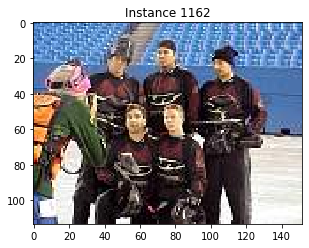

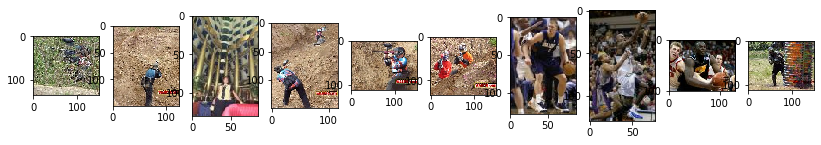

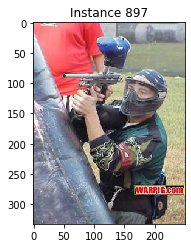

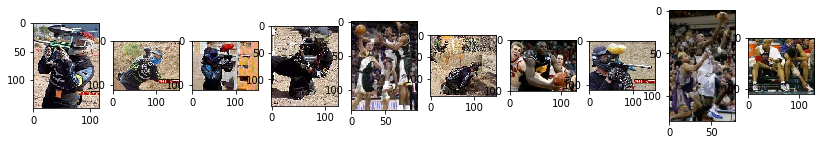

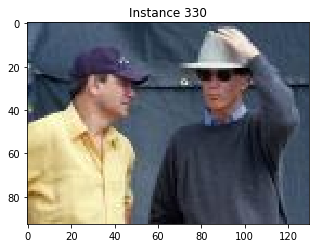

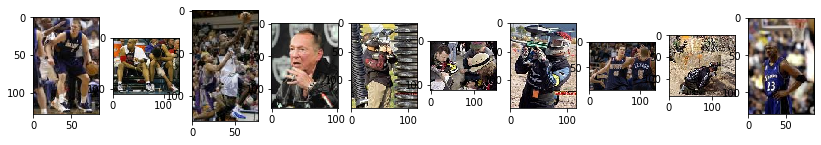

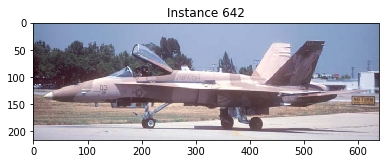

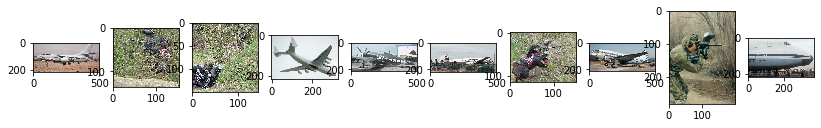

In [31]:
examples = [81,90,136,451]

for ij in examples:
    ii = idx_test[ij]
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title("Instance {0:d}".format(ii))
    ax1.imshow(pics_captions[ii][0])
    ff,aa = plt.subplots(1,10,figsize=(14,3))
    closest_images_id = closest_images_id_all[:,ij][::-1]
    closest_images_id = closest_images_id[:n_retrieve]
    closest_image_in_test_set = [idx_test[cc] for cc in closest_images_id]
    for jj in range(10):
        nn = closest_image_in_test_set[jj]
        aa[jj].imshow(pics_captions[nn][0])

# Assignment

## Extend the KLDA analysis of likeliness of each feature

- Explore for each of the three features: color, texture and bag-of-words, which is the kernel that achieves a better generalization using KLDA **(3 points)**
- **Extra** The two image features could be combined in a composite kernel (like those visited in the SVM assignment). Consider also KLDA with a kernel that is the sum of kernels on the two image features **(2 extra points)**

## Extend the KCCA content based retrieval to other kernels
- Explore combinations of the two image features as first view for the KCCA **(3 points)**

## Sensitiveness of the content based retrieval to its parameters
- The content based retrieval depends on these parameters:
 - kernel of each view
 - each view itself
 - number of images that are retrieved. Notice in this case there is no point in retrieving more than 200 images as the number of images in the test set of a same class is 200
 - number of KCCA components for each projection

Consider the views and kernels that reported the best results in the previous section and plot the evolution of the success rate in the retrieval as a function of the number of retrieved images and of the components of the KCCA (hint: Figure 3 and Table 3 of Hardoon , Szedmak and Shawe-Taylor 2004) **(4 points)**